In [1]:
from Methods.Adams import adams
from Methods.Euler import euler
from Methods.AdamsBashfortMoulton import abm
from Methods.PredictorCorrector import predictor_corrector as pred_corr
from Methods.RungeKutt import rk_a,rk_b
from Methods.Gir import gir
import numpy as np
from matplotlib import pyplot as plt

In [2]:
def fi(x):
    return np.sin(np.exp(x))


def dfi(x):
    return np.exp(x) * np.cos(np.exp(x))


def f(x, y):
    return dfi(x) + k * (y - fi(x))


def fi_m(x, initial_y, f):
    return fi(x)


In [3]:
class Method:
    def __init__(self, x0,xN,k,N, method_f,p,
                 require_additional = False, fi = None,dfi= None, name = 'y2',
                 _lambda = 0.1, is_iter = False, starter = None,y_num_to_start = 1):
        self.x0 = x0
        self.xN = xN
        self.k = k
        self.N = N
        self.require_additional = require_additional
        self.method_f = method_f
        self.fi = fi
        self.dfi = dfi
        self.name = name
        self._lambda = _lambda
        self.is_iter = is_iter
        self.starter = starter
        self.p = p
        self.y_num_to_start = y_num_to_start
        
    def calculate(self,initial_y,f,x0 = None,xN = None, N = -1):
        if N == -1:
            N = self.N
            
        if x0 is None:
            x0 = self.x0
        if xN is None:
            xN = self.xN
            
        result = np.zeros(N)
        nodes = np.linspace(x0, xN, N)
        if not (self.starter is None):
            x0_starter = self.x0
            xN_starter = nodes[self.y_num_to_start-1]
            initial_y = self.starter.calculate(initial_y,f, x0 = x0_starter, xN = xN_starter, N = self.y_num_to_start)
            
        nodes = np.linspace(x0, xN, N)
        
        if self.require_additional:
            result = self.method_f(nodes,initial_y,f,fi,k,dfi)
        elif self.is_iter:
            result = self.method_f(nodes,initial_y,self._lambda,f)
        else:
            result = self.method_f(nodes,initial_y,f)
        return result
    
    def form_title(self):
        result = ''
        if self.require_additional:
            result = self.name + ', N = '+ str(self.N)
        elif self.is_iter:
            result = self.name + ', L='+ str(self._lamda)+',N = '+ str(self.N)
        else:
            result = self.name + ', N = '+ str(self.N)
        

In [107]:
N = 5 * 2 ** 1
_N = 5 * 2 ** 6

#draw_step = max(1,int(N/_N))


k = 5
x0 = -1
xN = 2

fi_method = Method(x0,xN,0,N,fi_m,1, name = 'Исходная функция')
euler_method = Method(x0,xN,k,N,euler,1, name = 'явный метод Эйлера', y_num_to_start = 1)
adams_method = Method(x0,xN,k,N,adams,4, name = 'явный метод Адамса', y_num_to_start = 4)
pc_method = Method(x0,xN,k,N,pred_corr,2, name = 'метод типа предиктор-корректор', is_iter = True, _lambda = 0.01, y_num_to_start = 1)
abm_method = Method(x0,xN,k,N,abm,4, name = 'метод Адамса-Бэшфорта-Моултона', y_num_to_start = 4, starter = fi_method)
rka_method = Method(x0,xN,k,N,rk_a,3, name = 'метод Рунге-Кутты O(h^3)', y_num_to_start = 1)
rkb_method = Method(x0,xN,k,N,rk_b,4, name = 'метод Рунге-Кутты O(h^4)', y_num_to_start = 1)
gir_method = Method(x0,xN,k,N,gir,4,require_additional = True, fi = fi,dfi= dfi, name = 'метод Гира', y_num_to_start = 4)

euler_method.starter = fi_method
adams_method.starter = rkb_method
pc_method.starter = fi_method
abm_method.starter = rkb_method
rka_method.starter =  fi_method
rkb_method.starter = fi_method
gir_method.starter = rkb_method

methods = [euler_method,adams_method,pc_method,abm_method,rka_method,rkb_method,gir_method]
method_count = len(methods)

In [80]:

#nodes = np.linspace(x0, xN, N)
#y_fi = fi(nodes)
#nodes_draw = nodes[::draw_step]
#y_fi_draw = y_fi[::draw_step]

array([ 0.35963757,  0.49115666,  0.65677293,  0.84147098,  0.98314444,
        0.92770239,  0.41933608, -0.55842231, -0.82812697,  0.52909327])

In [5]:
def runge_rule(p,yh_2,yh):    
    return ((2**p)/(2**p -1) ) * (yh_2 - yh)

def compare(y1,y2):
    n = y1
    eps_global = np.abs(y1 - y2) 
    eps_local = eps_global / np.maximum(np.abs(y1),np.abs(y2))
    eps_max = np.max(eps_global)
    return eps_global,eps_local,eps_max



5
10
20
40
80


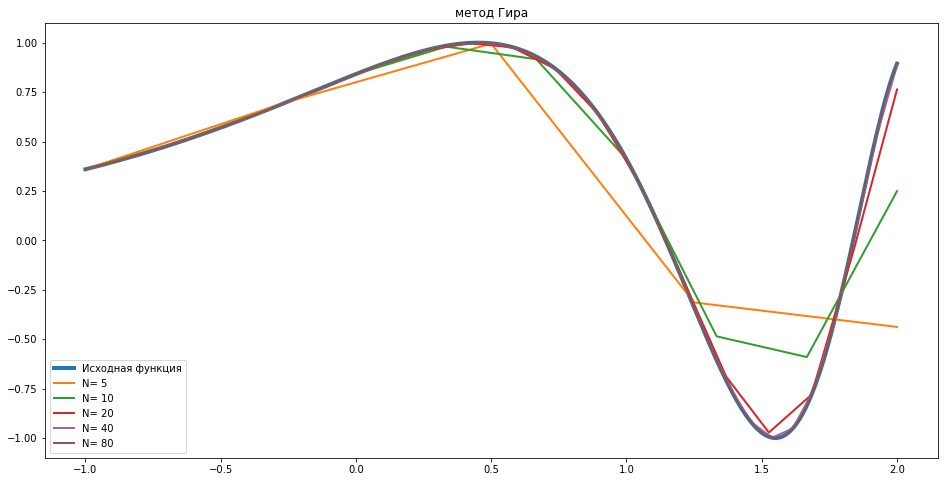

In [121]:
N_start = 5
method = gir_method


fig = plt.figure(figsize=(16,8))
plt.title(method.name)


nodes_draw = np.linspace(method.x0, method.xN, _N)


plt.plot(nodes_draw, fi(nodes_draw), label='Исходная функция', linewidth=4)

    
for i in range(0,5):
    current_n = int(N_start * (2**(i)))
    print(current_n)
    nodes = np.linspace(method.x0, method.xN, current_n)
    
    y = method.calculate(fi(nodes)[:4],f, N = current_n )
    plt.plot(nodes, y, label='N= '+str(current_n), linewidth=2)

plt.legend(loc='lower left')
#plt.show()
plt.savefig(method.name + ".png",dpi = 200)

In [97]:
n_s = [10,30,60,500]
nodes = np.linspace(x0, xN, current_n)

calculation_results = []
for current_n in n_s:
    tmp = []
    for method in methods:
        y = method.calculate(fi(nodes)[:4],f, N = current_n )
        tmp.append(y)
    calculation_results.append(tmp)
  
y_fi = fi(nodes)


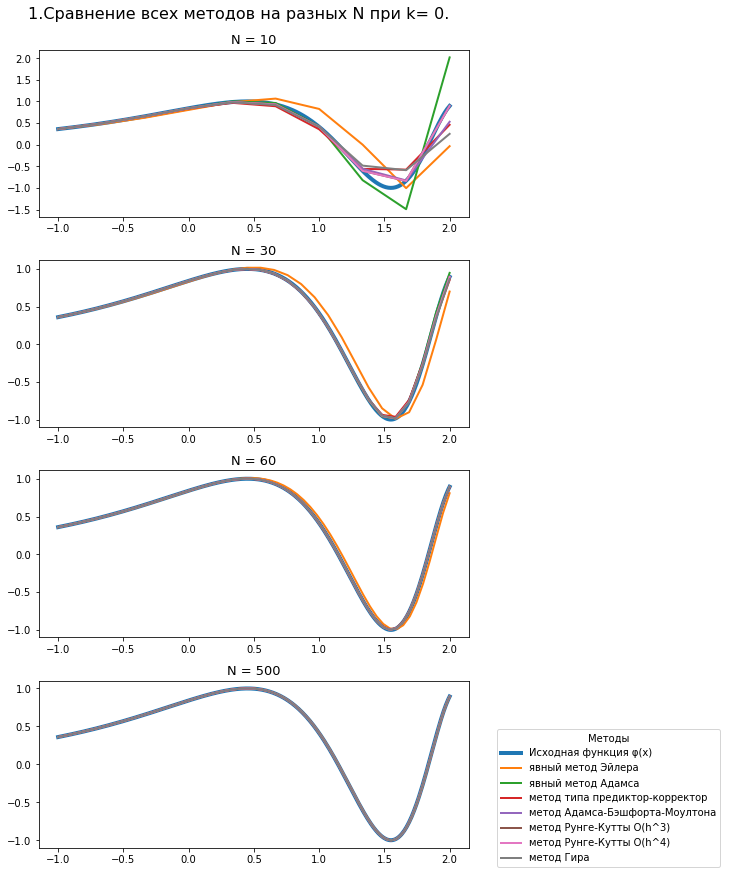

In [98]:
subplots = []
fig, subplots = plt.subplots(len(n_s),figsize=(6.5,3*len(n_s)), constrained_layout=True)

title = '1.Сравнение всех методов на разных N при k= ' +str(k)+'.'
fig.suptitle(title, fontsize=16)


nodes_draw = np.linspace(x0, xN, _N)

for sublot_num in range(len(subplots)):
    nodes = np.linspace(x0, xN, n_s[sublot_num])
    subplot = subplots[sublot_num]
    subplot.set_title('N = '+str(n_s[sublot_num]),fontsize=13)
    subplot.plot(nodes_draw, fi(nodes_draw), label='Исходная функция φ(x)', linewidth=4)
    for i in range(method_count):
        subplot.plot(nodes, calculation_results[sublot_num][i], label=str(methods[i].name), linewidth=2)
                     
line_labels = ["Исходная функция φ(x)"]+[m.name for m in methods]
#ax1.legend(loc='lower left')
fig.legend(line_labels,     # The line objects
              # The labels for each line
           loc="lower center",   # Position of legend
           borderaxespad=0.5,    # Small spacing around legend box
           title="Методы",  # Title for the legend
           bbox_to_anchor=(1.3, 0)
           )
fig.savefig('images/graph1.png',dpi = 200)

In [101]:
def calculate_real_p(eps):
    
    n,m = eps.shape
    result = np.zeros((n,m-1))
    for i in range(n):
        for j in range(m-1):
             result[i,j] = log( \
                                abs( eps[i,j] / eps[i,j+1] )\
                                ) / log(2)
    return result

In [108]:
import pandas as pd
from math import log

iteration_count = 20

N_test =( 5 * (2**np.linspace(0,iteration_count-1,iteration_count))).astype('int32') 

result = np.zeros((method_count,iteration_count ))

i = -1
for n in N_test:
    i+=1
    nodes = np.linspace(x0,xN,n)
    y_fi = fi(nodes)
    j = -1
    for method in methods:
        j+=1
        y_method = method.calculate(y_fi[:4],f, N = n )
        _,_,eps = compare(y_fi,y_method)
        result[j,i] = eps
        print(i,j)

methods_names = [m.name for m in methods]
err_df = pd.DataFrame(result, index=methods_names, columns=list(N_test))


p_calculated = calculate_real_p(result)
        
p_calculated_real = np.concatenate([p_calculated, np.zeros((method_count,1))], axis = 1)

for method_num in range(method_count):
    p_calculated_real[method_num,iteration_count-1] = methods[method_num].p

p_calculated_df = pd.DataFrame(p_calculated_real, index=methods_names, columns=list(N_test)[:-1] +['p'] )

0 0
0 1
0 2
0 3
0 4
0 5
0 6
1 0
1 1
1 2
1 3
1 4
1 5
1 6
2 0
2 1
2 2
2 3
2 4
2 5
2 6
3 0
3 1
3 2
3 3
3 4
3 5
3 6
4 0
4 1
4 2
4 3
4 4
4 5
4 6
5 0
5 1
5 2
5 3
5 4
5 5
5 6
6 0
6 1
6 2
6 3
6 4
6 5
6 6
7 0
7 1
7 2
7 3
7 4
7 5
7 6
8 0
8 1
8 2
8 3
8 4
8 5
8 6
9 0
9 1
9 2
9 3
9 4
9 5
9 6
10 0
10 1
10 2
10 3
10 4
10 5
10 6
11 0
11 1
11 2
11 3
11 4
11 5
11 6
12 0
12 1
12 2
12 3
12 4
12 5
12 6
13 0
13 1
13 2
13 3
13 4
13 5
13 6
14 0
14 1
14 2
14 3
14 4
14 5
14 6
15 0
15 1
15 2
15 3
15 4
15 5
15 6
16 0
16 1
16 2
16 3
16 4
16 5
16 6
17 0
17 1
17 2
17 3
17 4
17 5
17 6
18 0
18 1
18 2
18 3
18 4
18 5
18 6
19 0
19 1
19 2
19 3
19 4
19 5
19 6


In [109]:
pd.options.display.float_format = '{:.2e}'.format
err_df

,5,10,20,40,80,160,320,640,1280,2560,5120,10240,20480,40960,81920,163840,327680,655360,1310720,2621440
явный метод Эйлера,4.21e+00,4.55e+01,2.51e+02,6.81e+02,9.86e+02,9.05e+02,6.28e+02,3.72e+02,2.03e+02,1.06e+02,5.42e+01,2.74e+01,1.38e+01,6.91e+00,3.46e+00,1.73e+00,8.66e-01,4.33e-01,2.16e-01,1.08e-01
явный метод Адамса,7.10e+02,1.83e+02,1.84e+01,4.89e+00,7.43e-01,6.46e-02,4.69e-03,3.15e-04,2.04e-05,1.30e-06,8.19e-08,4.48e-09,7.91e-10,1.19e-09,2.17e-09,3.09e-09,2.00e-09,1.74e-10,3.77e-10,5.51e-09
метод типа предиктор-корректор,2.39e+02,1.27e+03,1.73e+03,8.92e+02,2.90e+02,7.92e+01,2.05e+01,5.18e+00,1.30e+00,3.26e-01,8.16e-02,2.04e-02,5.10e-03,1.28e-03,3.19e-04,7.90e-05,2.06e-05,6.61e-06,7.01e-06,1.09e-05
метод Адамса-Бэшфорта-Моултона,8.13e+02,1.30e+02,8.13e+01,1.88e+02,1.20e+02,4.44e+01,1.33e+01,3.60e+00,9.37e-01,2.39e-01,6.03e-02,1.51e-02,3.80e-03,9.50e-04,2.38e-04,5.87e-05,1.55e-05,5.35e-06,6.69e-06,1.09e-05
метод Рунге-Кутты O(h^3),8.31e+02,1.37e+03,4.38e+02,7.18e+01,9.77e+00,1.26e+00,1.60e-01,2.02e-02,2.53e-03,3.17e-04,3.96e-05,5.00e-06,5.23e-07,1.50e-07,1.53e-07,7.88e-07,6.63e-07,1.62e-06,5.77e-06,1.12e-05
метод Рунге-Кутты O(h^4),2.19e+03,9.35e+02,9.69e+01,6.97e+00,4.59e-01,2.94e-02,1.86e-03,1.17e-04,7.33e-06,4.56e-07,1.68e-08,4.39e-08,9.41e-08,7.67e-08,1.64e-07,7.89e-07,6.63e-07,1.62e-06,5.77e-06,1.12e-05
метод Гира,1.79e+02,2.41e+04,1.77e+02,1.09e+01,7.44e-01,4.84e-02,3.07e-03,1.93e-04,1.21e-05,7.13e-07,5.91e-08,1.34e-07,3.87e-07,9.46e-08,3.07e-07,7.94e-07,6.81e-06,1.91e-05,3.93e-05,8.77e-06


No handles with labels found to put in legend.


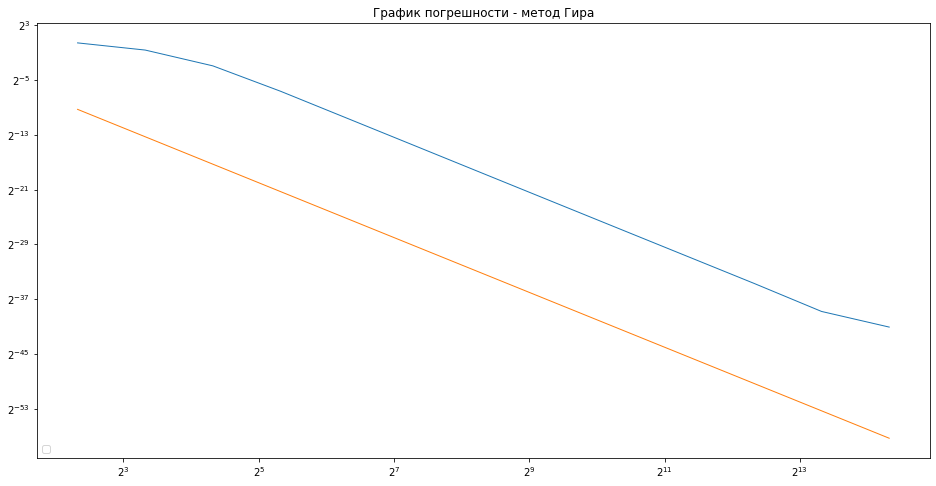

In [174]:
method_err_plot = gir_method
row = err_df.loc[method_err_plot.name]
size = row.shape[0]

err = [row.iloc[i] for i in range(size)]
N_test

fig = plt.figure(figsize=(16,8))
plt.title('График погрешности - ' + method_err_plot.name)
plt.yscale('log',basey=2) 
plt.xscale('log',basex=2) 
plt.plot(N_test,err, linewidth=1, label='') 
plt.plot(N_test,np.power(N_test.astype('float32'),-method_err_plot.p), linewidth=1) 
plt.legend(loc='lower left')

plt.savefig('images/ERR ='+''+'.png',dpi = 200)

In [148]:
pd.options.display.float_format = '{:.2f}'.format
p_calculated_df

,5,10,20,40,80,160,320,640,1280,2560,5120,10240,p
явный метод Эйлера,1.38,1.02,1.01,1.01,1.00,1.01,1.00,1.00,1.00,1.00,1.00,1.00,1.00
явный метод Адамса,2.43,2.01,3.95,4.04,4.02,4.01,4.01,4.00,4.00,4.00,4.00,3.97,4.00
метод типа предиктор-корректор,1.59,2.18,2.09,2.04,2.02,2.01,2.00,2.00,2.00,2.00,2.00,2.00,2.00
метод Адамса-Бэшфорта-Моултона,2.58,4.18,3.87,4.05,4.03,4.01,4.01,4.00,4.00,3.99,4.38,-1.11,4.00
метод Рунге-Кутты O(h^3),6.18,3.60,4.21,4.03,4.04,4.02,4.01,4.00,3.99,3.35,-1.20,-1.12,3.00
метод Рунге-Кутты O(h^4),6.18,3.60,4.21,4.03,4.04,4.02,4.01,4.00,3.99,3.35,-1.20,-1.12,4.00
метод Гира,1.05,2.31,3.70,4.00,4.01,4.01,4.01,4.00,4.00,4.00,4.10,2.28,4.00


In [141]:
test_method = abm_method

err = np.zeros((method_count,iteration_count))

for j in range(iteration_count):
        n = N_test[j]
        nodes = np.linspace(x0,xN,n)
        y_fi = fi(nodes)
        for i in range(method_count):
            method = methods[i]
            if method == test_method:
                continue    
            test_method.starter = method
            y_method = test_method.calculate([],f, N = n )
            _,_,eps = compare(y_fi,y_method)
            err[i,j] = eps

p = calculate_real_p(err)
p_df = pd.DataFrame(p, index=methods_names, columns=list(N_test)[:-1] )
p_df

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


,5,10,20,40,80,160,320,640,1280,2560,5120,10240
явный метод Эйлера,1.67,3.66,2.95,2.48,2.16,2.05,2.02,2.01,2.00,2.00,2.00,2.00
явный метод Адамса,2.58,4.18,3.87,4.05,4.03,4.01,4.01,4.00,4.00,3.99,4.38,-1.11
метод типа предиктор-корректор,2.63,4.20,3.88,4.07,4.06,4.09,3.97,3.68,3.56,3.41,3.29,1.61
метод Адамса-Бэшфорта-Моултона,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
метод Рунге-Кутты O(h^3),2.58,4.18,3.87,4.05,4.03,4.01,4.01,4.00,4.00,3.99,4.38,-1.11
метод Рунге-Кутты O(h^4),2.58,4.18,3.87,4.05,4.03,4.01,4.01,4.00,4.00,3.99,4.38,-1.11
метод Гира,2.58,4.18,3.87,4.05,4.03,4.01,4.01,4.00,4.00,3.99,4.38,-1.11


In [ ]:
# итерационные методы